# Demonstração Filtro Inverso

A filtragem inversa é um método de restauração que tenta recuperar uma imagem que sofreu transformação por um filtro linear invariante (LTI) connhecido. O experimento mostrado aqui é apenas uma demonstração didática e consiste de uma imagem alterada por um filtro LTI conhecido na qual será aplicada a inversa deste filtro para recuperar a imagem original.

In [1]:
#copia funções necessarias
import numpy as np

def iaptrans(f,t):
    g = np.empty_like(f) 
    if f.ndim == 1:
        W = f.shape[0]
        col = np.arange(W)
        g = f[(col-t)%W]
    elif f.ndim == 2:
        H,W = f.shape
        rr,cc = t
        row,col = np.indices(f.shape)
        g = f[(row-rr)%H, (col-cc)%W]
    elif f.ndim == 3:
        Z,H,W = f.shape
        zz,rr,cc = t
        z,row,col = np.indices(f.shape)
        g = f[(z-zz)%Z, (row-rr)%H, (col-cc)%W]
    return g
#-------------------------------------

def iafftshift(f):
    return iaptrans(f, np.array(f.shape)//2)
#-------------------------------------

def bwlp(fsize, tc, n, option='circle'):

    def test_exp(x, y):
        try:
            return x**(2*y)
        except:
            return 1E300 # Infinito!

    rows, cols = fsize[0], fsize[1]
    mh, mw = rows//2, cols//2
    rr, cc = np.meshgrid(np.arange(-mh,rows-mh), np.arange(-mw,cols-mw), indexing='ij') # center
    
    if str.find(str.upper(option), 'SQUARE') != -1:
        H = 1./(1.+(sqrt(2)-1)*(maximum(abs(1.*rr/rows) , abs(1.*cc/cols))*tc)**(2*n))
    else:
        aux1 = np.ravel(np.sqrt(((1.*rr)/rows)**2 + ((1.*cc)/cols)**2)*tc)
        aux2 = 0.*aux1 + n
        aux = np.reshape(list(map(test_exp, aux1, aux2)), cc.shape)
        H = 1./(1+(np.sqrt(2)-1)*aux)
    H = iafftshift(H)
    return H
#-------------------------------------


## Imagem original e imagem filtrada

A imagem original será filtrada por meio de um filtro butterworth (cuttoff de 16 pixels e ordem 4). O efeito é similar ao de uma imagem fora de foco.

""
Imagem original
""
Imagem filtrada

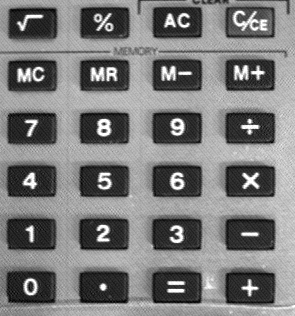
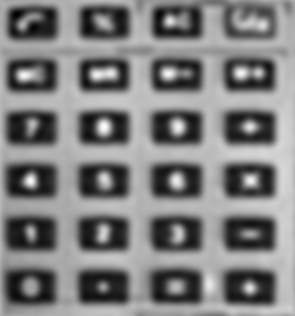

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys,os
ia898path = os.path.abspath('/home/lotufo')
if ia898path not in sys.path:
    sys.path.append(ia898path)
import ia898.src as ia
os.chdir('/home/lotufo/ia898/data')
    
f = mpimg.imread('keyb.tif').astype(float)

F = np.fft.fft2(f)
H = bwlp(f.shape, 16, 4)
G = F*H
g = np.fft.ifft2(G)

nb = ia.nbshow(2)
nb.nbshow(ia.normalize(f),'Imagem original')
nb.nbshow(ia.normalize(g.real),'Imagem filtrada')
nb.nbshow()

## Visualiza espectro
Observar a imagem filtrada no dominio da frequencia e a inversa do espectro do filtro

""
Espectro da imagem filtrada
""
Espectro do filtro utilizado
""
Espectro inverso do filtro utilizado

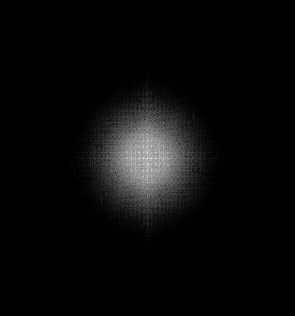
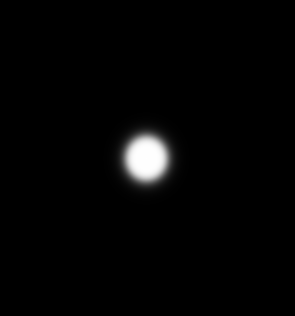
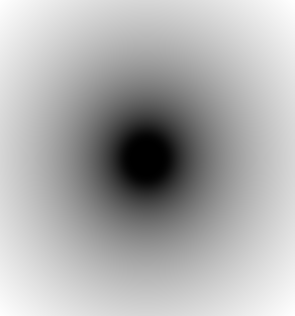

In [3]:
IH = 1.0/H

nb = ia.nbshow(3)
nb.nbshow(ia.dftview(G),'Espectro da imagem filtrada')
nb.nbshow(ia.dftview(H),'Espectro do filtro utilizado')
nb.nbshow(ia.dftview(IH),'Espectro inverso do filtro utilizado')
nb.nbshow()

## Aplicar o filtro inverso
Aplicar o filtro inverso, ou seja, multiplicar o espectro da imagem filtrada pelo inverso do espectro do filtro utilizado.
Após isso, reconstruir a imagem e comparar com a original.

""
Espectro da imagem original
""
Espectro da imagem restaurada
""
Imagem original
""
Imagem restaurada

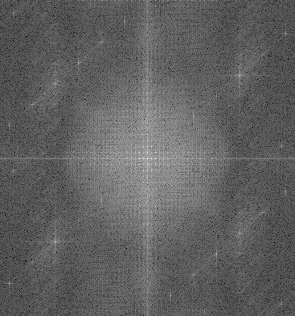
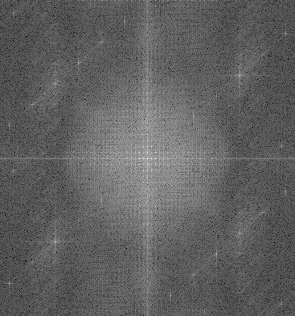
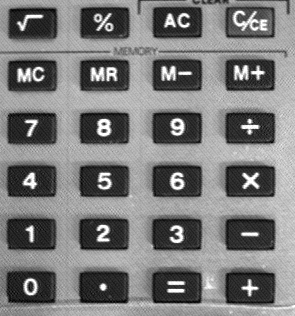
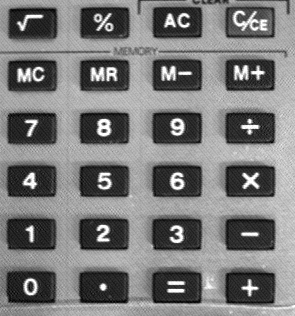

Diferença entre imagem original e restaurada: 3.75090856687e-08


In [4]:
FR = G*IH
fr = np.fft.ifft2(FR).real

nb = ia.nbshow(2)
nb.nbshow(ia.dftview(F),'Espectro da imagem original')
nb.nbshow(ia.dftview(FR),'Espectro da imagem restaurada')
nb.nbshow(ia.normalize(f),'Imagem original')
nb.nbshow(ia.normalize(fr),'Imagem restaurada')
nb.nbshow()

print('Diferença entre imagem original e restaurada:', np.sum(np.sum(abs(f-fr))))
 

## Adicionando ruído

A seguir, o mesmo processo é repetido, porém, a imagem filtrada é arredondada para numeros inteiros antes de aplicar o filtro inverso.

""
Espectro da imagem filtrada
""
Espectro da imagem filtrada e arredondada
""
Imagem filtrada
""
Imagem filtrada e arredondada

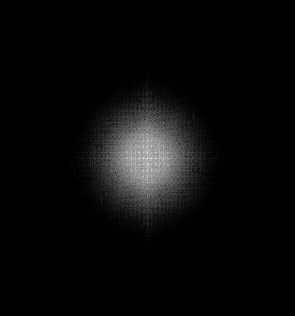
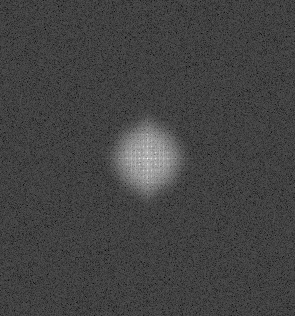
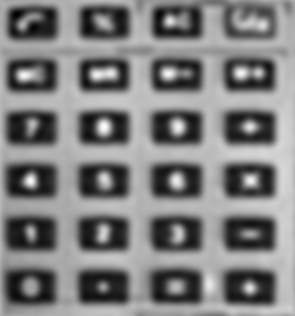
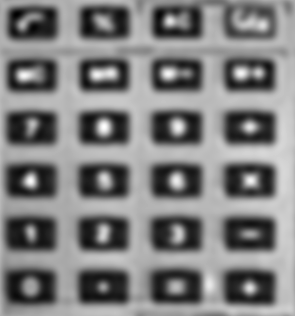

""
Espectro da imagem original
""
Espectro da imagem restaurada
""
Imagem original
""
Imagem restaurada

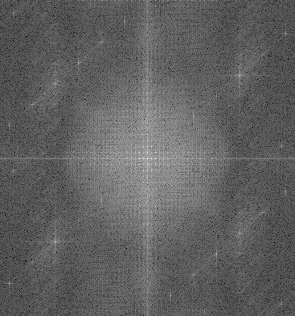
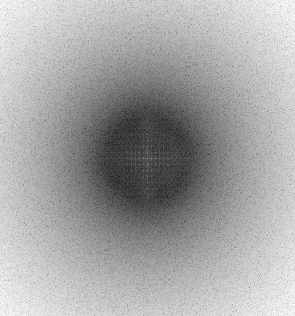
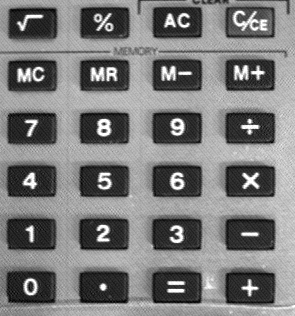
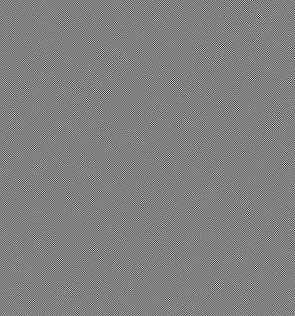

Diferença entre imagem original e restaurada: 278141578319.0


In [5]:
f = mpimg.imread('keyb.tif').astype(float)
F = np.fft.fft2(f)
H = bwlp(f.shape, 16, 4)
G = F*H
g = np.fft.ifft2(G).real

gfix = np.floor(g)
Gfix = np.fft.fft2(gfix)
IH = 1.0/H

FRfix = Gfix*IH 
frfix = np.fft.ifft2(FRfix).real

nb = ia.nbshow(2)
nb.nbshow(ia.dftview(G),'Espectro da imagem filtrada')
nb.nbshow(ia.dftview(Gfix),'Espectro da imagem filtrada e arredondada')
nb.nbshow(ia.normalize(g),'Imagem filtrada')
nb.nbshow(ia.normalize(gfix),'Imagem filtrada e arredondada')
nb.nbshow()

nb = ia.nbshow(2)
nb.nbshow(ia.dftview(F),'Espectro da imagem original')
nb.nbshow(ia.dftview(FRfix),'Espectro da imagem restaurada')
nb.nbshow(ia.normalize(f),'Imagem original')
nb.nbshow(ia.normalize(frfix),'Imagem restaurada')
nb.nbshow()

print('Diferença entre imagem original e restaurada:', np.sum(np.sum(abs(f-frfix))))



Note que a imagem reconstruída (dominio espacial e frequencia) parece conter apenas ruído. Isso ocorre pois o arredondamento da imagem filtrada é equivalente a introduzir um ruído de alta frequencia. Ao aplicar o filtro inverso, estamos aplicando um filtro passa alta o que intensifica os componentes de alta frequencia.

Como introduzimos um ruído de alta frequencia na imagem, este passa a ser dominante distorcendo toda a imagem e impedindo a reconstrução da visualização original.

Media do ruído introduzido: 0.499409994031
Min do ruído introduzido: 9.29635160674e-06
Max do ruído introduzido: 0.9999606292

Min do ruído restaurado: -15348654.7842
Max do ruído restaurado: 15787958.4307
Min da imagem original: 0.0
Max da imagem original: 255.0

Note que os valores absolutos do ruído são muito maiores que o valor dos pixels da imagem original.
Assim sendo, a imagem restaurada será dominada pelo ruído devido a amplificação introduzida pela filtragem inversa.


""
Visualização do ruído
""
Espectro do ruído
""
Restauração do ruído

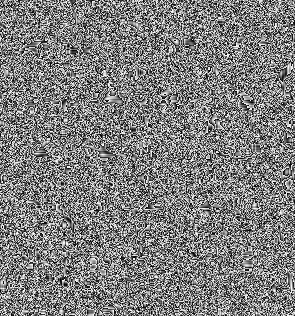
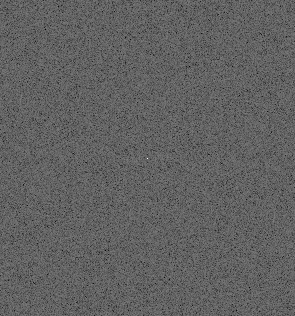
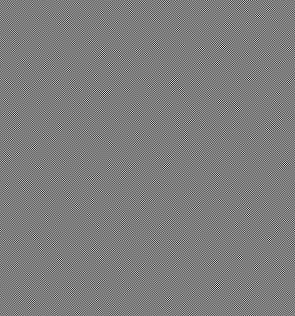

In [6]:
fn = g - gfix
print('Media do ruído introduzido:',fn.mean())
print('Min do ruído introduzido:',fn.min())
print('Max do ruído introduzido:',fn.max())

FN = np.fft.fft2(fn)
FNI = FN*IH
fni = np.fft.ifft2(FNI).real
print('\nMin do ruído restaurado:',fni.min())
print('Max do ruído restaurado:',fni.max())
print('Min da imagem original:',f.min())
print('Max da imagem original:',f.max())
print('\nNote que os valores absolutos do ruído são muito maiores que o valor dos pixels da imagem original.')
print('Assim sendo, a imagem restaurada será dominada pelo ruído devido a amplificação introduzida pela filtragem inversa.')

nb = ia.nbshow(3)
nb.nbshow(ia.normalize(fn,),'Visualização do ruído')
nb.nbshow(ia.dftview(FN),'Espectro do ruído')
nb.nbshow(ia.normalize(fni),'Restauração do ruído')
nb.nbshow()

## outra possibilidade... encontrar o filtro utilizado

Uma outra possibilidade que segue a mesma lógica do filtro inverso, seria encontrar o filtro (h) utilizado em uma dada imagem, conhendo a imagem original (f) e a imagem filtrada (g).

O exemplo a baixo mostra essa solução. Note que os passos são os mesmos do filtro inverso, porém na frequencia temos G = F * H, de tal forma que H = G/F e por fim h = ifft(H)

""
Imagem original (f)
""
Imagem filtrada (g)
""
Espectro do filtro utilizado (h)

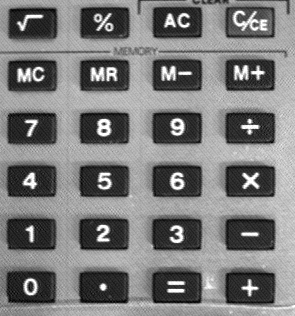
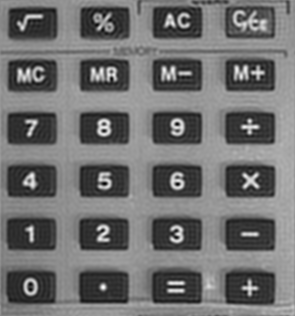
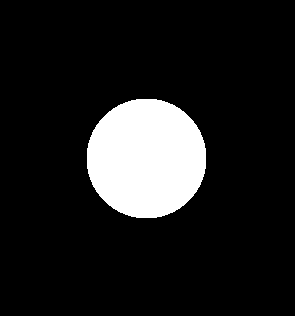


Utilizando apenas f e h, encontrar o filtro:


""
Espectro inverso da imagem (F_inv)
""
Espectro da imagem filtrada (G)
""
Espectro do filtro reconstruido (G * F_inv)

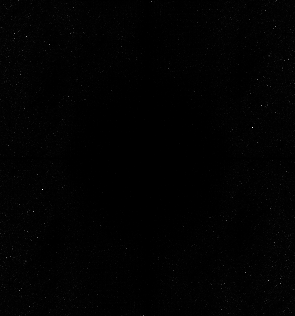
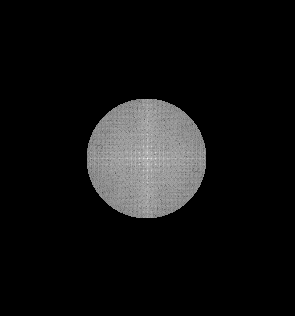
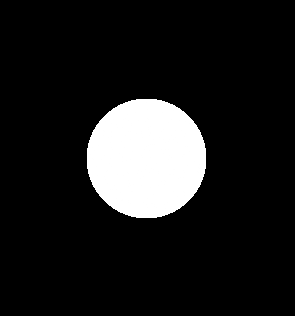

Diferença entre filtro original e restaurado: 5.66998498904e-13


In [7]:
f = mpimg.imread('keyb.tif').astype(float)

F = np.fft.fft2(f)
H = np.zeros_like(F)

r,c = np.indices( (316, 295) )
H = ( (r-316//2)**2 + (c-295//2)**2 < 60**2)
H = ia.ptrans(H,(316//2,295//2))
G = F*H
g = np.fft.ifft2(G)

nb = ia.nbshow(3)
nb.nbshow(ia.normalize(f),'Imagem original (f)')
nb.nbshow(ia.normalize(g.real),'Imagem filtrada (g)')
nb.nbshow(ia.dftview(H),'Espectro do filtro utilizado (h)')
nb.nbshow()

print('\nUtilizando apenas f e h, encontrar o filtro:')

F_inv = 1./F
H1 = G * F_inv
nb = ia.nbshow(3)
nb.nbshow(ia.dftview(F_inv),'Espectro inverso da imagem (F_inv)')
nb.nbshow(ia.dftview(G),'Espectro da imagem filtrada (G)')
nb.nbshow(ia.dftview(H1),'Espectro do filtro reconstruido (G * F_inv)')
nb.nbshow()

print('Diferença entre filtro original e restaurado:', np.sum(np.sum(abs(H-H1))))


## Adicionando ruído
Note que o mesmo problema ocorre ao adicionar ruído na imagem filtrada. O filtro reconstruído não é mais idêntico ao original.

""
Imagem original (f)
""
Imagem filtrada e arredondada (g)
""
Espectro do filtro utilizado (h)

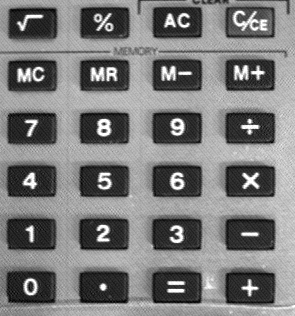
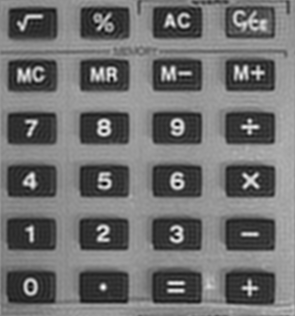
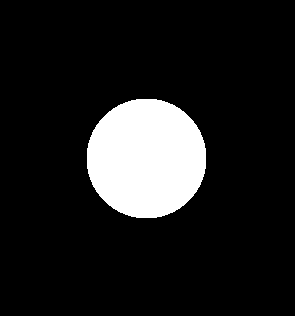


Utilizando apenas f e h, encontrar o filtro:


""
Espectro inverso da imagem (F_inv)
""
Espectro da imagem filtrada e arredondada (G)
""
Espectro do filtro reconstruido (G * F_inv)

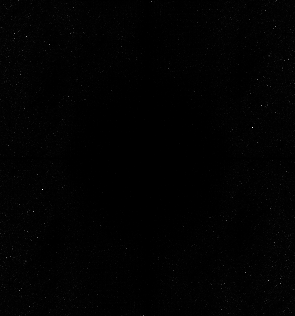
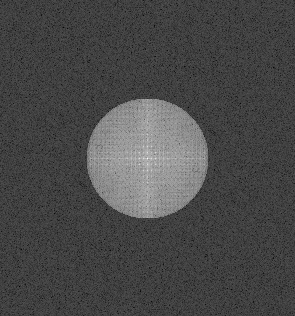
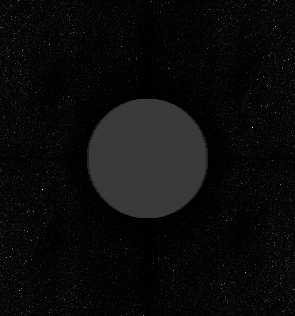

Diferença entre filtro original e restaurado: 6763.45938182


In [8]:
f = mpimg.imread('keyb.tif').astype(float)

F = np.fft.fft2(f)
H = np.zeros_like(F)

r,c = np.indices( (316, 295) )
H = ( (r-316//2)**2 + (c-295//2)**2 < 60**2)
H = ia.ptrans(H,(316//2,295//2))
G = F*H
g = np.fft.ifft2(G)

g = np.floor(g.real)
G = np.fft.fft2(g)

nb = ia.nbshow(3)
nb.nbshow(ia.normalize(f),'Imagem original (f)')
nb.nbshow(ia.normalize(g.real),'Imagem filtrada e arredondada (g)')
nb.nbshow(ia.dftview(H),'Espectro do filtro utilizado (h)')
nb.nbshow()

print('\nUtilizando apenas f e h, encontrar o filtro:')

F_inv = 1./F
H1 = G * F_inv
nb = ia.nbshow(3)
nb.nbshow(ia.dftview(F_inv),'Espectro inverso da imagem (F_inv)')
nb.nbshow(ia.dftview(G),'Espectro da imagem filtrada e arredondada (G)')
nb.nbshow(ia.dftview(H1),'Espectro do filtro reconstruido (G * F_inv)')
nb.nbshow()

print('Diferença entre filtro original e restaurado:', np.sum(np.sum(abs(H-H1))))


## Resolvendo o problema do ruído

Existem diversos métodos para resolver o problema do filtro inverso em uma imagem com ruído. Aqui apresentamos 2 deles no calculo do filtro inverso sobre a imagem filtrada e arredondada.

### Wiener Filtering
Dado um filtro H, o seu inverso é calculado como H*/(|H|² + K), onde K deve ser a densidade espectral média dos ruídos presentes na imagem.

Para o caso K=0, obtemos o mesmo resultado do filtro inverso direto.

A imagem restaurada ainda que não seja identica a original, apresenta uma boa qualidade dado o ruído inserido.

""
Imagem filtrada e truncada
""
Espectro da imagem filtrada e truncada

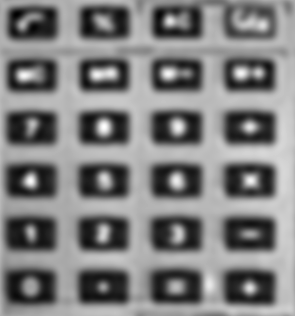
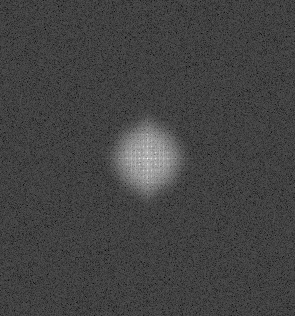

""
Espectro do filtro
""
Espectro inverso do filtro
""
Filtro inverso usando metodo Wiener

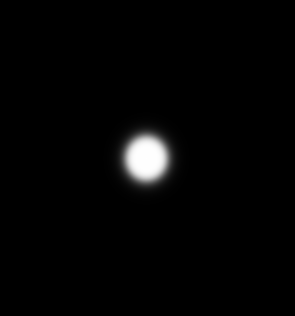
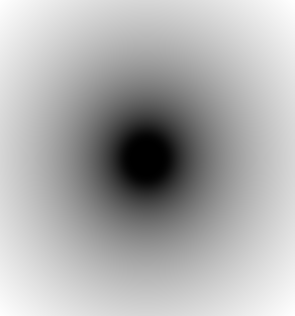
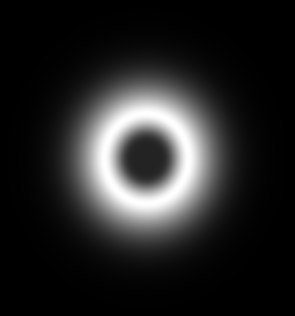

""
Espectro da imagem original
""
Espectro da imagem restaurada
""
Imagem original
""
Imagem restaurada

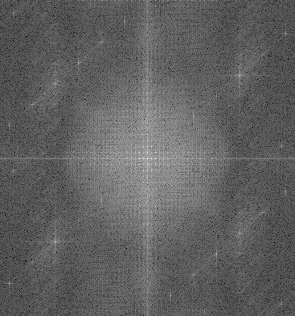
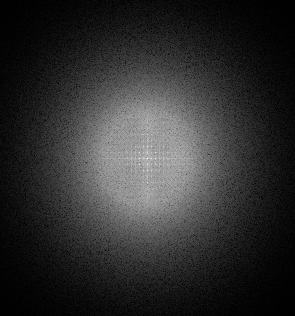
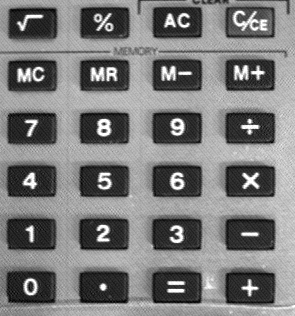
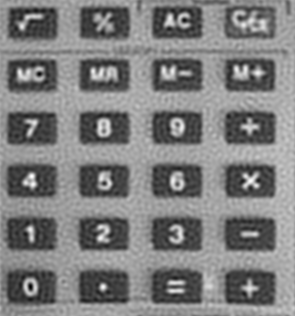

Diferença entre imagem original e restaurada: 1226396.93592


In [9]:
f = mpimg.imread('keyb.tif').astype(float)
F = np.fft.fft2(f)
H = bwlp(f.shape, 16, 4)
G = F*H
g = np.fft.ifft2(G).real
g = np.floor(g)
G = np.fft.fft2(g)

IH = np.conjugate(H) / (np.abs(H)**2 + 1/(316*295))

FR = G*IH 
fr = np.fft.ifft2(FR).real

nb = ia.nbshow(2)
nb.nbshow(ia.normalize(g),'Imagem filtrada e truncada')
nb.nbshow(ia.dftview(G),'Espectro da imagem filtrada e truncada')
nb.nbshow()


nb = ia.nbshow(3)
nb.nbshow(ia.dftview(H),'Espectro do filtro')
nb.nbshow(ia.dftview(1./H),'Espectro inverso do filtro')
nb.nbshow(ia.dftview(IH),'Filtro inverso usando metodo Wiener')
nb.nbshow()



nb = ia.nbshow(2)
nb.nbshow(ia.dftview(F),'Espectro da imagem original')
nb.nbshow(ia.dftview(FR),'Espectro da imagem restaurada')
nb.nbshow(ia.normalize(f),'Imagem original')
nb.nbshow(ia.normalize(fr),'Imagem restaurada')
nb.nbshow()

print('Diferença entre imagem original e restaurada:', np.sum(np.sum(abs(f-fr))))

## Pseudo inversa
Nesse método, uma frequencia (ou periodo) de corte é definida sobre o filtro inverso de maneira a não intensificar as altas frequencias (ou ruídos) ao restaurar a imagem.

IH = 1/H quando |H|> T

IH = 0 quando   |H|<=T

A imagem restaurada ainda que não seja identica a original, apresenta uma boa qualidade dado o ruído inserido.

""
Imagem filtrada e truncada
""
Espectro da imagem filtrada e truncada

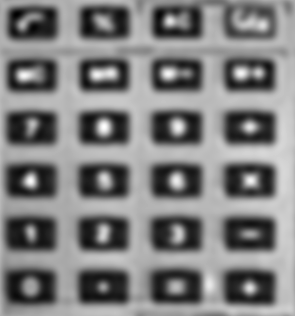
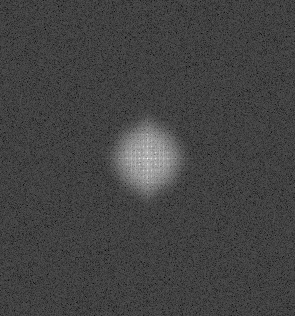

""
Espectro do filtro
""
Espectro inverso do filtro
""
Filtro inverso usando pseudo-inversa

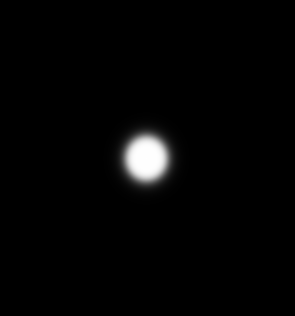
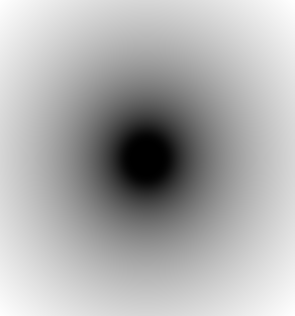
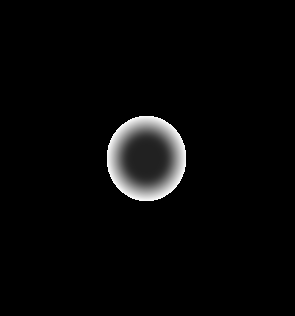

""
Espectro da imagem original
""
Espectro da imagem restaurada
""
Imagem original
""
Imagem restaurada

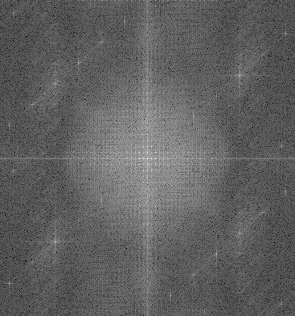
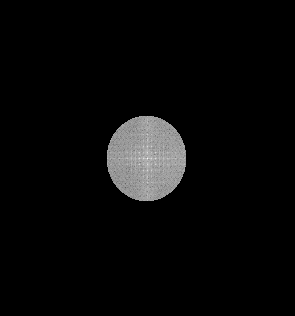
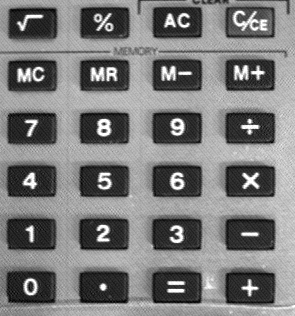
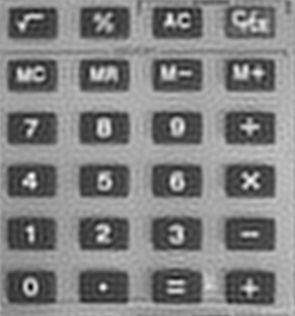

Diferença entre imagem original e restaurada: 1223644.44358


In [10]:
f = mpimg.imread('keyb.tif').astype(float)
F = np.fft.fft2(f)
H = bwlp(f.shape, 16, 4)
G = F*H
g = np.fft.ifft2(G).real
g = np.floor(g)
G = np.fft.fft2(g)

T = 1/(200)
IH = np.where(np.abs(H)>T,1./H,0)

FR = G*IH 
fr = np.fft.ifft2(FR).real

nb = ia.nbshow(2)
nb.nbshow(ia.normalize(g),'Imagem filtrada e truncada')
nb.nbshow(ia.dftview(G),'Espectro da imagem filtrada e truncada')
nb.nbshow()


nb = ia.nbshow(3)
nb.nbshow(ia.dftview(H),'Espectro do filtro')
nb.nbshow(ia.dftview(1./H),'Espectro inverso do filtro')
nb.nbshow(ia.dftview(IH),'Filtro inverso usando pseudo-inversa')
nb.nbshow()



nb = ia.nbshow(2)
nb.nbshow(ia.dftview(F),'Espectro da imagem original')
nb.nbshow(ia.dftview(FR),'Espectro da imagem restaurada')
nb.nbshow(ia.normalize(f),'Imagem original')
nb.nbshow(ia.normalize(fr),'Imagem restaurada')
nb.nbshow()

print('Diferença entre imagem original e restaurada:', np.sum(np.sum(abs(f-fr))))